# ResNet18 Mechanistic Interpretability
Explore internal representations of a ResNet18 model trained on NFFA-SEM.

In [31]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torchvision.transforms.functional import to_pil_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = '/content/drive/MyDrive/Colab Notebooks/NFFA-SEM/data/processed'
model_path = '/content/drive/MyDrive/Colab Notebooks/NFFA-SEM/outputs/20250430_024232_lr0.0001_bs32/model.pth'
batch_size = 32
input_size = (224, 224)
subset_ratio = 0.1
random_seed = 42


In [33]:
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
subset_size = int(len(dataset) * subset_ratio)
subset, _ = random_split(dataset, [subset_size, len(dataset) - subset_size], generator=torch.Generator().manual_seed(random_seed))

train_size = int(0.8 * len(subset))
val_size = int(0.1 * len(subset))
test_size = len(subset) - train_size - val_size

train_set, _, test_set = random_split(subset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(random_seed))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [34]:
backbone = models.resnet18(pretrained=False)
backbone.fc = nn.Linear(backbone.fc.in_features, len(class_names))
backbone.load_state_dict(torch.load(model_path, map_location=device))
backbone = backbone.to(device)
backbone.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])
    def forward(self, x):
        x = self.features(x)
        return torch.flatten(x, 1)
model = FeatureExtractor(backbone).to(device)


In [36]:
def extract_features(loader):
    features, labels = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            feats = model(inputs)
            features.append(feats.cpu().numpy())
            labels.extend(targets.numpy())
    return np.concatenate(features), np.array(labels)

# train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)


<ipython-input-37-4b1c5cb71e3a>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


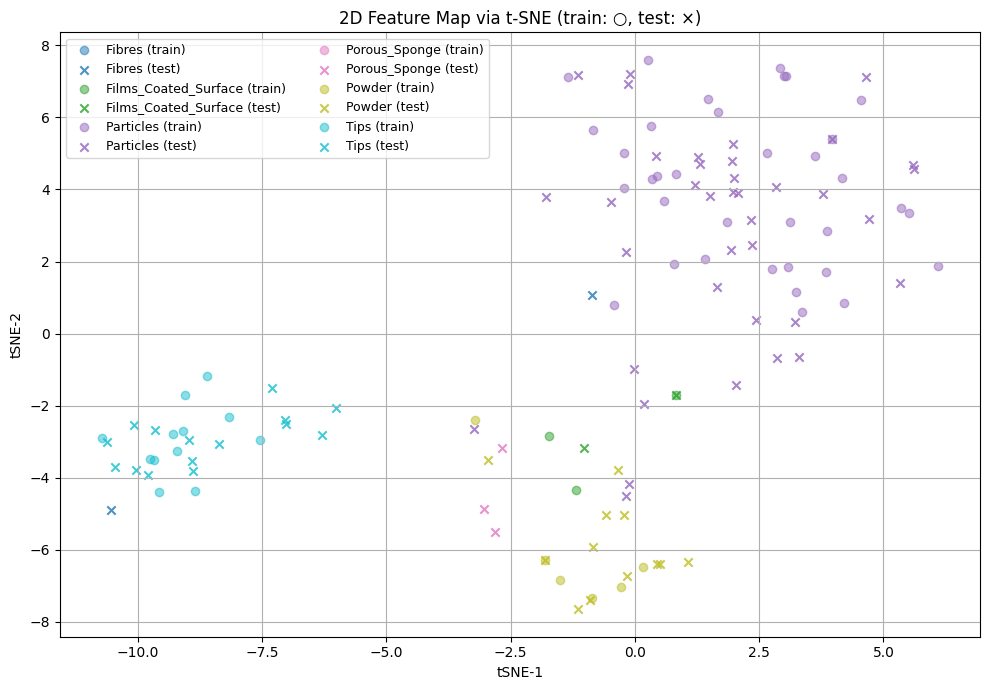

In [37]:
all_features = np.vstack([train_features, test_features])
pca = PCA(n_components=50)
reduced = pca.fit_transform(all_features)

tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', perplexity=30)
all_proj = tsne.fit_transform(reduced)

train_proj = all_proj[:len(train_features)]
test_proj = all_proj[len(train_features):]

colors = plt.cm.get_cmap('tab10', len(class_names))
plt.figure(figsize=(10, 7))
for class_idx, class_name in enumerate(class_names):
    train_mask = train_labels == class_idx
    test_mask = test_labels == class_idx
    plt.scatter(train_proj[train_mask, 0], train_proj[train_mask, 1], marker='o', color=colors(class_idx), label=f"{class_name} (train)", alpha=0.5)
    plt.scatter(test_proj[test_mask, 0], test_proj[test_mask, 1], marker='x', color=colors(class_idx), label=f"{class_name} (test)", alpha=0.8)
plt.title("2D Feature Map via t-SNE (train: ○, test: ×)")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.legend(ncol=2, fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
# Feature Map Visualizer
def show_layer_activation(model, layer_name, input_tensor):
    activation = {}
    def hook_fn(module, input, output):
        activation[layer_name] = output.detach().cpu()
    hook = dict([*model.named_modules()])[layer_name].register_forward_hook(hook_fn)
    model.eval()
    with torch.no_grad():
        model(input_tensor.unsqueeze(0).to(device))
    act = activation[layer_name][0]
    fig, axs = plt.subplots(1, min(8, act.size(0)), figsize=(20, 5))
    for i in range(min(8, act.size(0))):
        axs[i].imshow(act[i])
        axs[i].axis('off')
        axs[i].set_title(f'Channel {i}')
    plt.suptitle(f"Activation Maps: {layer_name}")
    plt.show()
    hook.remove()


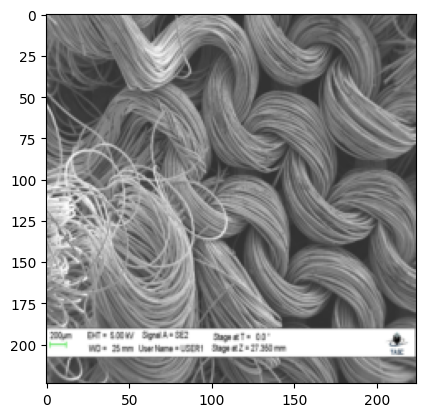

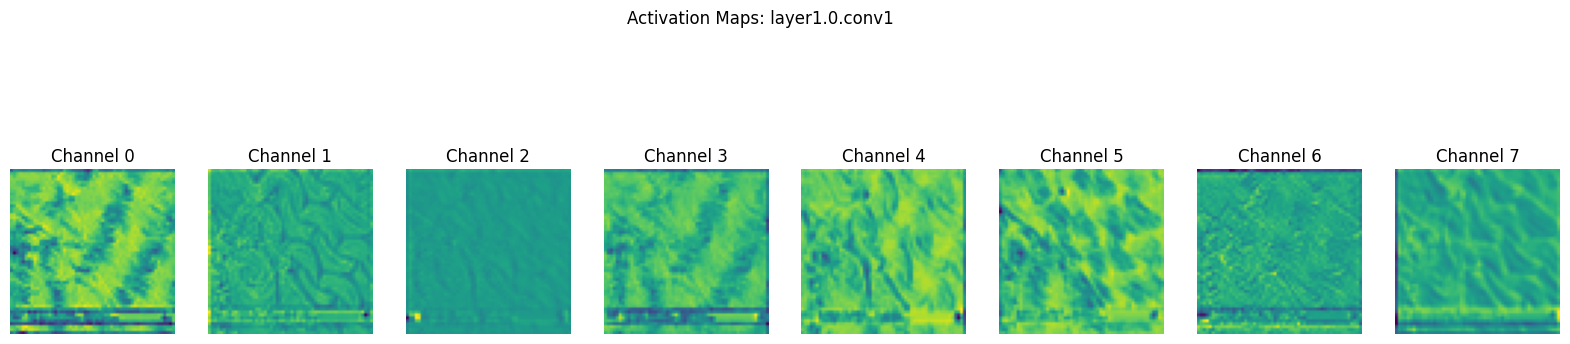

In [39]:
# 1枚の画像を取得
img_tensor, label = dataset[0]  # ← ImageFolderで読み込み済み前提

# 画像を表示して確認
from matplotlib.pyplot import imshow
imshow(to_pil_image(img_tensor))

# layer_nameは model.named_modules() で確認できるレイヤー名の文字列
show_layer_activation(model=backbone, layer_name='layer1.0.conv1', input_tensor=img_tensor)

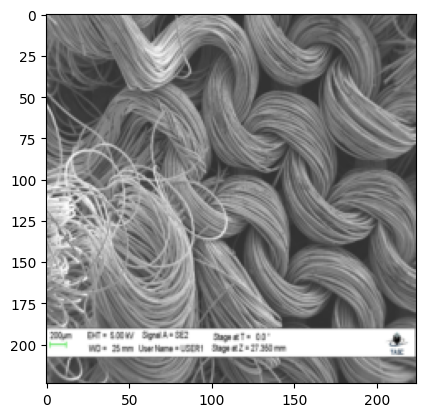

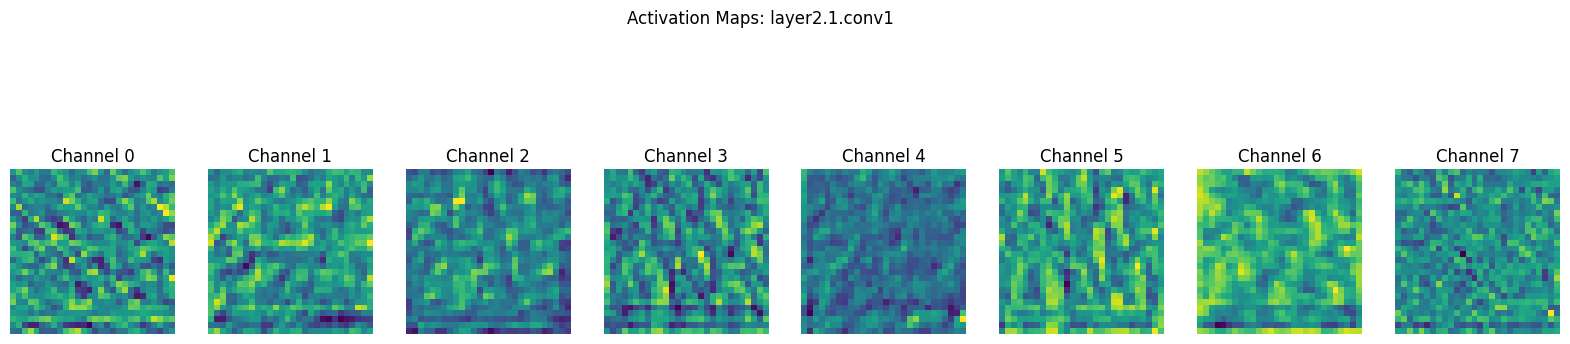

In [40]:
# 1枚の画像を取得
img_tensor, label = dataset[0]  # ← ImageFolderで読み込み済み前提

# 画像を表示して確認
imshow(to_pil_image(img_tensor))

# layer_nameは model.named_modules() で確認できるレイヤー名の文字列
show_layer_activation(model=backbone, layer_name='layer2.1.conv1', input_tensor=img_tensor)

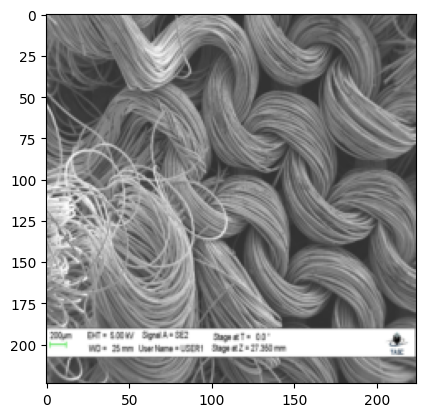

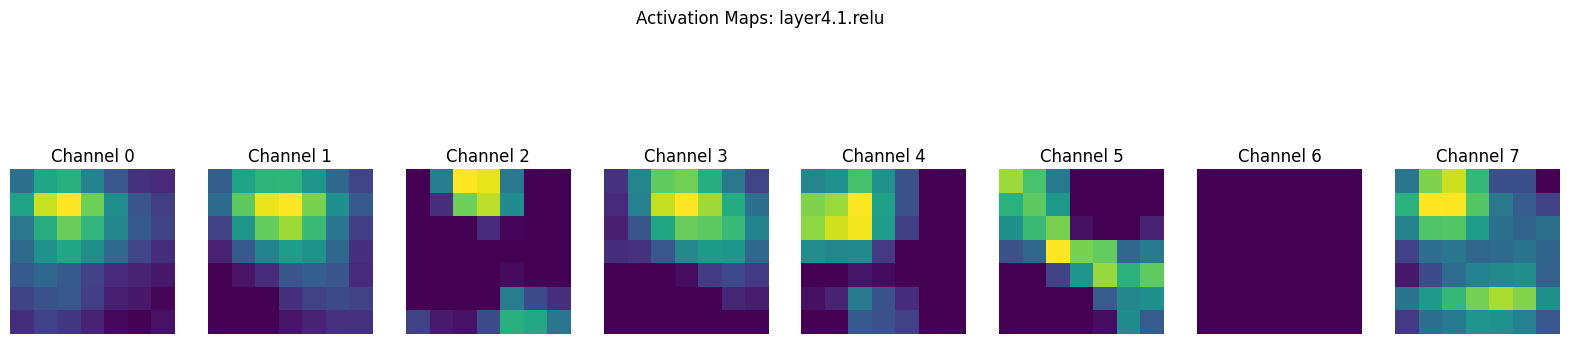

In [41]:
# 1枚の画像を取得
img_tensor, label = dataset[0]  # ← ImageFolderで読み込み済み前提

# 画像を表示して確認
from matplotlib.pyplot import imshow
imshow(to_pil_image(img_tensor))

# layer_nameは model.named_modules() で確認できるレイヤー名の文字列
show_layer_activation(model=backbone, layer_name='layer4.1.relu', input_tensor=img_tensor)

## チャネル別に最大反応画像を保存するスクリプト

In [42]:
import torch
import torchvision
import os
from torchvision.transforms.functional import to_pil_image
from PIL import Image

# === 設定 ===
target_layer = 'layer1.0.conv1'  # 対象レイヤー名
target_channel = 3               # 対象チャネル番号
top_k = 5                        # 保存する上位枚数
# save_dir = './channel_max_response'  # 保存先ディレクトリ
save_dir = '/content/drive/MyDrive/Colab Notebooks/NFFA-SEM/scripts/channel_max_response'

os.makedirs(save_dir, exist_ok=True)

# === Hookで出力をキャプチャ ===
activations = []
image_paths = []

def hook_fn(module, input, output):
    # output shape: [B, C, H, W]
    # 平均活性化（Global Average）を記録
    channel_activations = output[:, target_channel, :, :].mean(dim=[1,2])  # shape: [B]
    activations.extend(channel_activations.cpu().tolist())

# Hook登録
hook = dict([*backbone.named_modules()])[target_layer].register_forward_hook(hook_fn)

# === データ走査とスコア記録 ===
backbone.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        backbone(inputs)  # hookで出力が記録される

# Hook解除
hook.remove()

# === 上位画像を保存 ===
# 元画像はSubsetなのでindex逆引き
subset_indices = test_set.indices if isinstance(test_set, Subset) else range(len(test_set))
original_dataset = test_set.dataset.dataset if isinstance(test_set.dataset, Subset) else test_set.dataset

# スコア順にソート
top_indices = sorted(range(len(activations)), key=lambda i: activations[i], reverse=True)[:top_k]

for rank, idx in enumerate(top_indices):
    original_idx = subset_indices[idx]
    img_tensor, _ = original_dataset[original_idx]
    img = to_pil_image(img_tensor)
    img.save(os.path.join(save_dir, f"rank{rank+1}_act{activations[idx]:.4f}.png"))

print(f"Top {top_k} images saved to: {save_dir}")

Top 5 images saved to: /content/drive/MyDrive/Colab Notebooks/NFFA-SEM/scripts/channel_max_response


## チャネル別にアブレーション実験を行うスクリプト

In [43]:
import torch
import torch.nn.functional as F

# === 設定 ===
target_layer = 'layer1.0.conv1'  # アブレーション対象のレイヤー名
target_channel = 3               # 無効化したいチャネル番号

# === Hookによるチャネルアブレーション関数 ===
def ablation_hook_fn(module, input, output):
    # 出力 shape: [B, C, H, W]
    output[:, target_channel, :, :] = 0  # 指定チャネルだけ0にする
    return output

# === Hook登録 ===
hook = dict([*backbone.named_modules()])[target_layer].register_forward_hook(ablation_hook_fn)

# === 精度測定（アブレーションあり） ===
def evaluate_model(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# 通常精度（比較用）
hook.remove()  # 一旦フック外す
normal_acc = evaluate_model(backbone, test_loader)

# アブレーションあり
hook = dict([*backbone.named_modules()])[target_layer].register_forward_hook(ablation_hook_fn)
ablation_acc = evaluate_model(backbone, test_loader)

# Hook解除
hook.remove()

# === 結果表示 ===
print(f"Normal Accuracy:    {normal_acc:.4f}")
print(f"Ablated Accuracy:   {ablation_acc:.4f}")
print(f"Accuracy Drop:      {normal_acc - ablation_acc:.4f}")

Normal Accuracy:    0.8889
Ablated Accuracy:   0.8750
Accuracy Drop:      0.0139


## Channel wise abration

Baseline Accuracy: 0.8889
Channel  0 | Accuracy drop: 0.0000
Channel  1 | Accuracy drop: 0.0000
Channel  2 | Accuracy drop: 0.0000
Channel  3 | Accuracy drop: 0.0000
Channel  4 | Accuracy drop: 0.0000
Channel  5 | Accuracy drop: 0.0000
Channel  6 | Accuracy drop: 0.0000
Channel  7 | Accuracy drop: 0.0000
Channel  8 | Accuracy drop: 0.0000
Channel  9 | Accuracy drop: 0.0000
Channel 10 | Accuracy drop: 0.0000
Channel 11 | Accuracy drop: 0.0000
Channel 12 | Accuracy drop: 0.0000
Channel 13 | Accuracy drop: 0.0000
Channel 14 | Accuracy drop: 0.0000
Channel 15 | Accuracy drop: 0.0000
Channel 16 | Accuracy drop: 0.0000
Channel 17 | Accuracy drop: 0.0000
Channel 18 | Accuracy drop: 0.0000
Channel 19 | Accuracy drop: 0.0000
Channel 20 | Accuracy drop: 0.0000
Channel 21 | Accuracy drop: 0.0000
Channel 22 | Accuracy drop: 0.0000
Channel 23 | Accuracy drop: 0.0000
Channel 24 | Accuracy drop: 0.0000
Channel 25 | Accuracy drop: 0.0000
Channel 26 | Accuracy drop: 0.0000
Channel 27 | Accuracy drop: 0

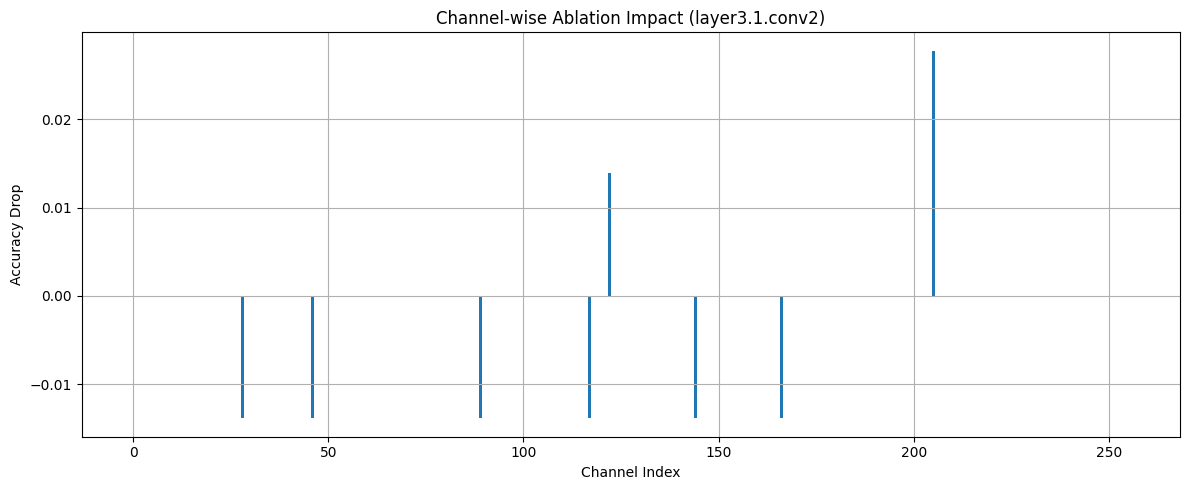

In [44]:
import torch
import matplotlib.pyplot as plt

# === 設定 ===
# target_layer = 'layer1.0.conv1'
target_layer = 'layer3.1.conv2'
target_channel = 3               # 無効化したいチャネル番号

layer_module = dict([*backbone.named_modules()])[target_layer]
num_channels = layer_module.out_channels  # 例: 64

# === 精度評価関数（アブレーションなし） ===
def evaluate(model):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# 通常精度（baseline）
normal_acc = evaluate(backbone)
print(f"Baseline Accuracy: {normal_acc:.4f}")

# === 各チャネルアブレーション評価 ===
channel_scores = []

for ch in range(num_channels):
    def hook_fn(module, input, output):
        output[:, ch, :, :] = 0
        return output

    hook = layer_module.register_forward_hook(hook_fn)
    ablated_acc = evaluate(backbone)
    hook.remove()

    drop = normal_acc - ablated_acc
    channel_scores.append(drop)
    print(f"Channel {ch:2d} | Accuracy drop: {drop:.4f}")

# === グラフ表示 ===
plt.figure(figsize=(12, 5))
plt.bar(range(num_channels), channel_scores)
plt.xlabel("Channel Index")
plt.ylabel("Accuracy Drop")
plt.title(f"Channel-wise Ablation Impact ({target_layer})")
plt.grid(True)
plt.tight_layout()
plt.show()

## channel number

* 最初は 64チャネルからスタート
* 層が深くなるごとに 64→128→256→512 に増加
* 最終特徴ベクトルの次元は 512

層名,出力チャネル数,説明
conv1,64,最初の 7×7 畳み込み層
layer1,64,残差ブロック × 2（浅い層）
layer2,128,中間層、空間解像度を半分に
layer3,256,より深い層
layer4,512,最も深い層
avgpool,512,グローバル平均プール
fc（全結合）,出力クラス数,分類（例：1000クラスなど）


## how do we know from this result?
- X-axis: Channel index (0–255 in layer3.1.conv2)

- Y-axis: Change in accuracy when that channel is ablated (i.e., set to 0)
	•	Positive value: Accuracy dropped → channel was helpful
	•	Zero: No change → channel was irrelevant or redundant
	•	Negative value: Accuracy improved → channel was possibly harmful (overfitting, noise)


### Result(observation)
1.	Most channels have near-zero impact
→ Suggests redundancy or robustness: model isn’t sensitive to most individual channels
	2.	A few channels (e.g., ~200) cause noticeable accuracy drop
→ These are functionally important channels: they encode key features used for decision-making
	3.	Some channels give negative drops (accuracy ↑)
→ These may be:
	•	Noisy / overfitting channels
	•	Misleading features
	•	Or simply interactions with residual connections


1. Feature attribution at the channel level
	•	Identify critical channels responsible for performance
	•	Can guide interpretability: “what kind of feature does Channel 200 encode?”

2. Model compression / pruning
	•	Channels with zero or negative importance can be pruned
	•	Leads to a more compact model with little or no accuracy loss

3. Error diagnosis
	•	Harmful channels might be encoding spurious patterns (e.g., background noise, text overlays)


### Next step
 can help you:
	1.	Visualize the most important channel’s feature maps
	2.	Save input images where that channel was most active
	3.	Suggest which channels to prune and test effect

In [45]:
print(len(test_loader.dataset))

72
